Iniciando EDA para la Datathon...
Archivo '../mango/train.csv' cargado exitosamente.

--- 1.1. Información General del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95339 entries, 0 to 95338
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  95339 non-null  int64  
 1   id_season           95339 non-null  int64  
 2   aggregated_family   95339 non-null  object 
 3   family              95339 non-null  object 
 4   category            95339 non-null  object 
 5   fabric              95339 non-null  object 
 6   color_name          95339 non-null  object 
 7   color_rgb           95339 non-null  object 
 8   image_embedding     95339 non-null  object 
 9   length_type         86830 non-null  object 
 10  silhouette_type     82972 non-null  object 
 11  waist_type          23252 non-null  object 
 12  neck_lapel_type     58874 non-null  object 
 13  sleeve_length_type

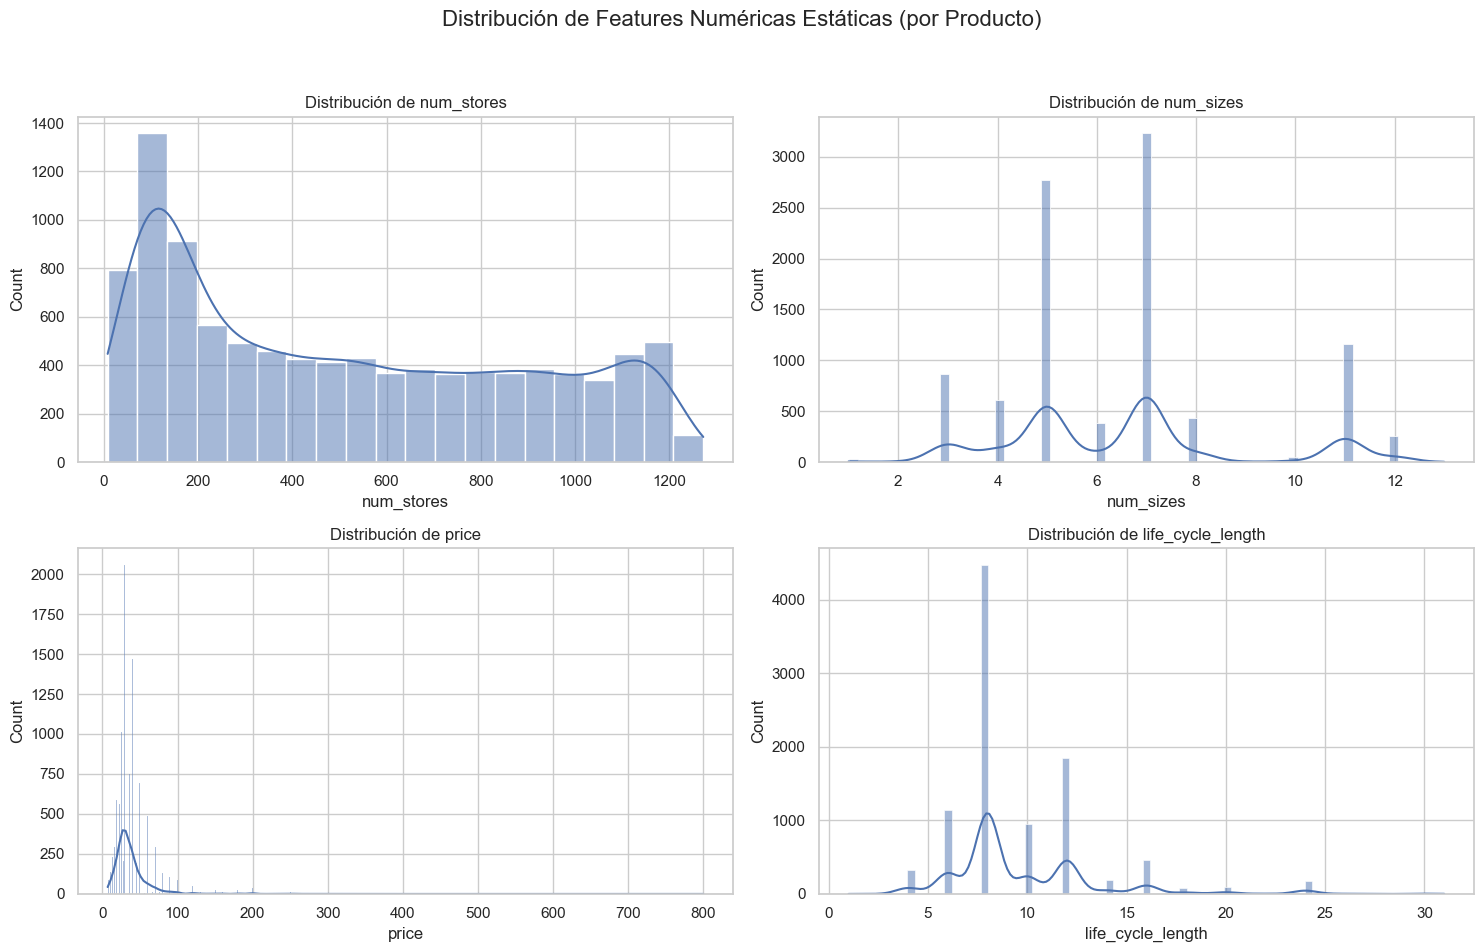

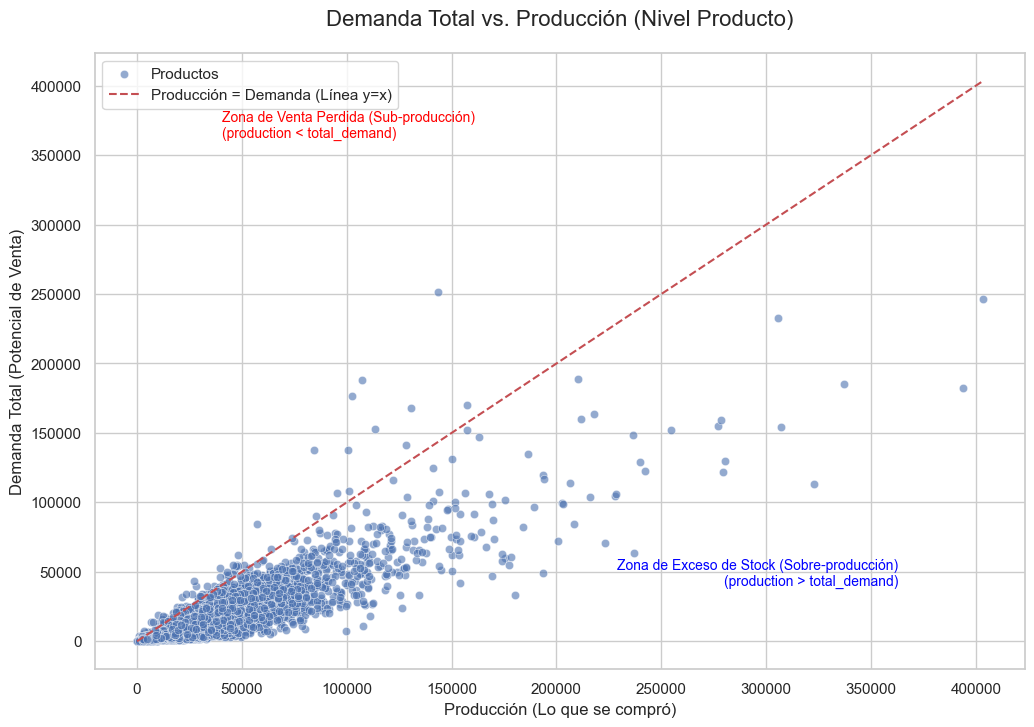

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Configuración ---
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

print("Iniciando EDA para la Datathon...")

# --- 1. Carga y Vistazo Inicial ---
# NOTA: He usado 'train_sample.csv' (el archivo de muestra)
# Cambia esto a tu archivo 'train.csv' completo cuando lo ejecutes.
file_name = "../mango/train.csv"
try:
    df = pd.read_csv(file_name, delimiter=';')
    print(f"Archivo '{file_name}' cargado exitosamente.")
    
    print("\n--- 1.1. Información General del DataFrame ---")
    df.info()

    print("\n--- 1.2. Primeras Filas (Head) ---")
    print(df.head())

    print("\n--- 1.3. Valores Nulos ---")
    # Imprimimos solo las columnas que SÍ tienen nulos para ser más concisos
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0])

except Exception as e:
    print(f"Error al cargar el archivo: {e}")
    # Salimos si no se puede cargar el archivo
    exit()

# --- 2. Análisis Nivel Producto (Features Estáticas - Fase 1 y 2) ---
# Estas son las features que definen el "QUÉ" y el "CONTEXTO"

print("\n--- 2.1. Cardinalidad (Valores Únicos) ---")
# Usamos try-except para cada print de cardinalidad por si alguna otra columna falta
try:
    print(f"Productos (ID) únicos: {df['ID'].nunique()}")
    print(f"Temporadas (id_season) únicas: {df['id_season'].nunique()}")
    print(f"Familias (family) únicas: {df['family'].nunique()}")
    print(f"Categorías (category) únicas: {df['category'].nunique()}")
    print(f"Siluetas (silhouette_type) únicas: {df['silhouette_type'].nunique()}")
    print(f"Momentos (moment) únicos: {df['moment'].nunique()}")
    
    # --- CORRECCIÓN ---
    # La columna 'ocassion' (con dos 's') no existe en la cabecera que proporcionaste.
    # La comentamos para evitar el 'KeyError'.
    # print(f"Ocasiones (ocassion) únicas: {df['ocassion'].nunique()}")
    
    # Verificamos si existe 'occasion' (con una 's')
    if 'occasion' in df.columns:
        print(f"Ocasiones (occasion) únicas: {df['occasion'].nunique()}")
    else:
        print("La columna 'ocassion' u 'occasion' no se encontró.")
        
except KeyError as e:
    print(f"Error de columna en Cardinalidad: {e}")


# --- 2.2. Distribución de Features Numéricas Estáticas (Contexto - Fase 2) ---
static_num_cols = ['num_stores', 'num_sizes', 'price', 'life_cycle_length']
product_level_static = df.drop_duplicates(subset=['ID'])

print(f"\n--- 2.3. Descriptivos de Features Numéricas (por Producto) ---")
existing_static_cols = [col for col in static_num_cols if col in product_level_static.columns]
if existing_static_cols:
    print(product_level_static[existing_static_cols].describe())
else:
    print("Ninguna de las columnas numéricas estáticas esperadas se encontró.")

# Graficamos sus distribuciones
if len(existing_static_cols) > 0:
    num_cols_plot = len(existing_static_cols)
    fig_cols = 2
    fig_rows = int(np.ceil(num_cols_plot / fig_cols))
    
    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(15, 5 * fig_rows))
    fig.suptitle('Distribución de Features Numéricas Estáticas (por Producto)', fontsize=16)
    
    axes = axes.flatten() 
    
    for i, col in enumerate(existing_static_cols):
        # Solo graficar si la columna tiene datos no nulos
        if not product_level_static[col].isnull().all():
            sns.histplot(product_level_static[col], ax=axes[i], kde=True)
            axes[i].set_title(f'Distribución de {col}')
        else:
            axes[i].set_title(f'Distribución de {col} (Vacío)')
            axes[i].set_visible(False)
        
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.savefig('static_features_distribution.png')
    print("Guardado: 'static_features_distribution.png'")
else:
    print("No se generó el gráfico de distribución, columnas no encontradas.")


# --- 3. Análisis Nivel Semana (Series Temporales - Fase 2) ---
print("\n--- 3.1. Descriptivos de Targets y Sales (por Semana) ---")
time_series_cols = ['weekly_sales', 'weekly_demand', 'Production']
existing_ts_cols = [col for col in time_series_cols if col in df.columns]
if existing_ts_cols:
    print(df[existing_ts_cols].describe())
else:
    print("Columnas de series temporales no encontradas.")

if 'ID' in df.columns and 'Production' in df.columns:
    production_variability = df.groupby('ID')['Production'].nunique().max()
    print(f"\nMáximo de valores de 'Production' distintos por ID: {production_variability}")
    if production_variability == 1:
        print("Confirmado: 'Production' es una feature estática (constante por ID).")
    elif production_variability == 0:
         print("Advertencia: No hay datos de 'Production' para verificar su variabilidad.")
    else:
        print("Advertencia: 'Production' varía para un mismo ID. Esto es inesperado.")
else:
    print("No se pudo verificar la variabilidad de 'Production'. Faltan 'ID' o 'Production'.")

if 'weekly_sales' in df.columns and 'Production' in df.columns and 'life_cycle_length' in df.columns:
    df_safe = df[df['life_cycle_length'] > 0].copy()
    if not df_safe.empty and not df_safe['Production'].isnull().all():
        df_safe['avg_weekly_prod'] = df_safe['Production'] / df_safe['life_cycle_length']
        df_safe['sales_capped_by_prod'] = df_safe['weekly_sales'] < df_safe['avg_weekly_prod']
        print("\nRelación Ventas vs Producción (simplificado, media semanal):")
        print(df_safe['sales_capped_by_prod'].value_counts(normalize=True))
    else:
        print("No se pudo calcular la relación ventas vs producción (datos insuficientes).")
else:
    print("No se pudo calcular la relación ventas vs producción. Faltan columnas.")


# --- 4. El Gráfico Clave: Producción vs. Demanda Total (Fase 4) ---
if 'ID' in df.columns and 'weekly_demand' in df.columns and 'weekly_sales' in df.columns and 'Production' in df.columns:
    product_summary = df.groupby('ID').agg(
        total_demand=('weekly_demand', 'sum'),
        total_sales=('weekly_sales', 'sum'),
        production=('Production', 'first') 
    )

    print("\n--- 4.1. Descriptivos de Totales (por Producto) ---")
    print(product_summary[['total_demand', 'total_sales', 'production']].describe())

    # --- CORRECCIÓN GRÁFICO ---
    # Solo intentar graficar si hay datos (product_summary no está vacío y las columnas no son todas NaN)
    if not product_summary.empty and not product_summary['production'].isnull().all() and not product_summary['total_demand'].isnull().all():
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=product_summary, x='production', y='total_demand', alpha=0.6, label='Productos')

        max_val = max(product_summary['production'].max(), product_summary['total_demand'].max())
        min_val = min(product_summary['production'].min(), product_summary['total_demand'].min())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Producción = Demanda (Línea y=x)')

        plt.title('Demanda Total vs. Producción (Nivel Producto)', fontsize=16, pad=20)
        plt.xlabel('Producción (Lo que se compró)', fontsize=12)
        plt.ylabel('Demanda Total (Potencial de Venta)', fontsize=12)
        plt.legend()
        plt.text(max_val * 0.1, max_val * 0.9, 'Zona de Venta Perdida (Sub-producción)\n(production < total_demand)', color='red', fontsize=10, ha='left')
        plt.text(max_val * 0.9, max_val * 0.1, 'Zona de Exceso de Stock (Sobre-producción)\n(production > total_demand)', color='blue', fontsize=10, ha='right')

        #plt.savefig('production_vs_demand_scatter.png')
        print("Guardado: 'production_vs_demand_scatter.png'")
    else:
        print("No se generó el gráfico 'production_vs_demand_scatter.png', datos insuficientes en el archivo de muestra.")

else:
    print("No se pudo generar el resumen de producto. Faltan columnas clave (ID, weekly_demand, weekly_sales, Production).")


print("\n--- EDA Finalizado ---")


--- 4.A. Agregados por Producto (Demanda vs Ventas) ---
        total_demand   total_sales     lost_sales  capture_rate
count    9843.000000    9843.00000    9843.000000   9843.000000
mean    10820.920349    9182.59362    1638.326730      0.873095
std     16070.932711   13084.78103    4614.726129      0.133137
min        19.000000      12.00000       0.000000      0.091610
25%      1660.000000    1421.50000      77.000000      0.828434
50%      5230.000000    4641.00000     453.000000      0.913662
75%     14106.000000   12135.50000    1613.500000      0.965512
max    251724.000000  205485.00000  165764.000000      1.000000
Guardado: 'sales_vs_demand_scatter.png'

--- 4.B. Análisis de Serie Temporal (Ejemplo) ---
Graficando ejemplo de 'stockout' para el ID con más ventas perdidas: 12611.0
Guardado: 'weekly_demand_vs_sales_example.png'


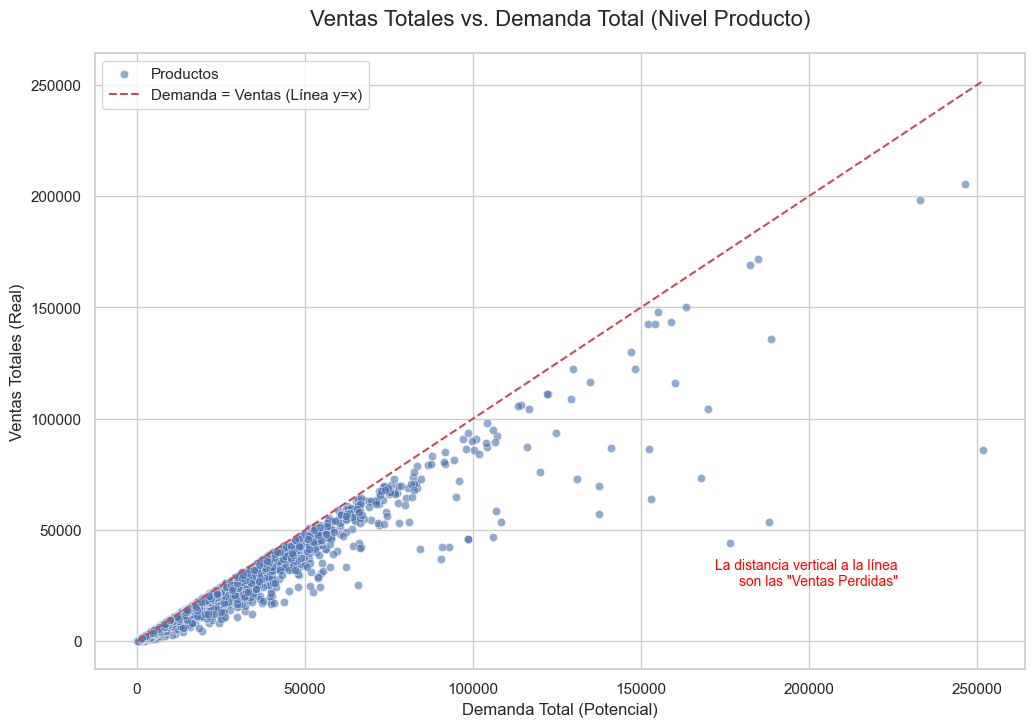

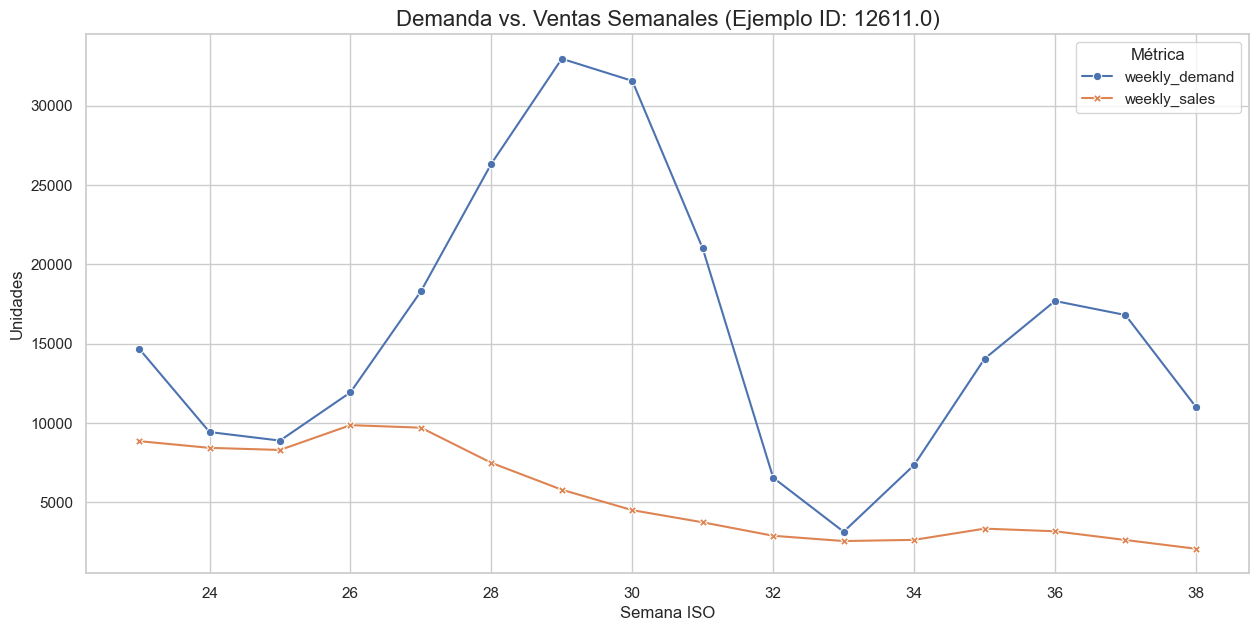

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ... Carga de df ...

# --- 4. Análisis Comparativo Demanda vs. Ventas ---

# --- 4.A. A Nivel de Producto (Agregado) ---
print("\n--- 4.A. Agregados por Producto (Demanda vs Ventas) ---")
product_summary = df.groupby('ID').agg(
    total_demand=('weekly_demand', 'sum'),
    total_sales=('weekly_sales', 'sum'),
    production=('Production', 'first')
).reset_index()

# --- ¡AQUÍ AÑADIMOS LAS NUEVAS MÉTRICAS! ---
# Ventas Perdidas
product_summary['lost_sales'] = product_summary['total_demand'] - product_summary['total_sales']

# Tasa de Captura (añadimos 1e-6 para evitar dividir por cero)
product_summary['capture_rate'] = product_summary['total_sales'] / (product_summary['total_demand'] + 1e-6)

print(product_summary[['total_demand', 'total_sales', 'lost_sales', 'capture_rate']].describe())

# --- GRÁFICO A: Scatter Plot (Ventas vs. Demanda) ---
if not product_summary.empty:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=product_summary, x='total_demand', y='total_sales', alpha=0.6, label='Productos')

    # Línea y=x (Captura Perfecta)
    max_val = max(product_summary['total_demand'].max(), product_summary['total_sales'].max())
    min_val = min(product_summary['total_demand'].min(), product_summary['total_sales'].min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Demanda = Ventas (Línea y=x)')

    plt.title('Ventas Totales vs. Demanda Total (Nivel Producto)', fontsize=16, pad=20)
    plt.xlabel('Demanda Total (Potencial)', fontsize=12)
    plt.ylabel('Ventas Totales (Real)', fontsize=12)
    plt.legend()
    plt.text(max_val * 0.9, max_val * 0.1, 'La distancia vertical a la línea\nson las "Ventas Perdidas"', color='red', fontsize=10, ha='right')
    
    #plt.savefig('sales_vs_demand_scatter.png')
    print("Guardado: 'sales_vs_demand_scatter.png'")

# --- 4.B. A Nivel Semanal (Serie Temporal) ---
print("\n--- 4.B. Análisis de Serie Temporal (Ejemplo) ---")

# Elegimos el producto con más ventas perdidas como ejemplo
if not product_summary.empty:
    id_example = product_summary.sort_values(by='lost_sales', ascending=False).iloc[0]['ID']
    print(f"Graficando ejemplo de 'stockout' para el ID con más ventas perdidas: {id_example}")

    # Filtramos el df original para ese ID
    df_example = df[df['ID'] == id_example].sort_values(by='num_week_iso')
    
    # Preparamos los datos para seaborn (formato 'long')
    df_example_melted = df_example.melt(
        id_vars=['num_week_iso'], 
        value_vars=['weekly_demand', 'weekly_sales'], 
        var_name='Metrica', 
        value_name='Unidades'
    )

    # --- GRÁFICO B: Serie Temporal (Demanda vs. Ventas) ---
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=df_example_melted, x='num_week_iso', y='Unidades', hue='Metrica', style='Metrica', markers=True, dashes=False)
    
    plt.title(f'Demanda vs. Ventas Semanales (Ejemplo ID: {id_example})', fontsize=16)
    plt.xlabel('Semana ISO', fontsize=12)
    plt.ylabel('Unidades', fontsize=12)
    plt.legend(title='Métrica')
    
    #plt.savefig('weekly_demand_vs_sales_example.png')
    print("Guardado: 'weekly_demand_vs_sales_example.png'")

else:
    print("No se generaron gráficos, datos insuficientes.")